In [286]:
import mainloc as m
# reload

# reload if it is neccesarry m.i.reload(m)
m.i.reload(m)

<module 'mainloc' from 'D:\\ITU-BOOK\\Bachelor-Project\\mainloc.py'>

In [59]:
m.links

['https://docs.google.com/document/d/1nJNTRmol4ymWYo0FJfWdZ3azY0MA1GzLiD9Hzr54dY0/edit',
 'https://docs.google.com/document/d/127Fu-z-c_WAIfmnDXootdAbibFylmHP0hJhB4WWNUVo/edit']

In [8]:
PATH = {}
PATH["weather"] = "data/weather/unprocessed/"
PATH["weather-processed"] = "data/weather/processed/"
UNITS = {}
MEASURES = ["NO2", "O3", "CO", "PM10", "PM25"]

FILES = {}
FILES["NO2"] = ["NO2_2018_y_t.nc","orig_NO2_2019_ym.nc","orig_NO2_2020_ym.nc","orig_NO2_2021_ym.nc"]
FILES["O3"] = ["O3_2018_y_t.nc","orig_O3_2019_ym.nc","orig_O3_2020_ym.nc","orig_O3_2021_ym.nc"]
FILES["CO"] = ["orig_CO_2019_ym.nc","orig_CO_2020_ym.nc","orig_CO_2021_ym.nc"]
FILES["PM10"] = ["orig_PM10_2019_ym.nc","orig_PM10_2020_ym.nc","orig_PM10_2021_ym.nc","PM10_2018_y_t.nc"]
FILES["PM25"] = ["orig_PM25_2019_ym.nc","orig_PM25_2020_ym.nc","orig_PM25_2021_ym.nc","PM25_2018_y_t.nc"]

#UNITS["NO2"] = "ug/m3"
#UNITS["O3"] = "ug/m3"
#UNITS["CO"] = "ppb"
#UNITS["PM10"] = "ug/m3"
#UNITS["PM25"] = "ug/m3"

FOCUS = "NO2"

In [11]:
def AverageAirQuality(FOCUS, FILES):
    unitsSet = []
    dfCounter = 0
    l = len(FILES)
    valueLists = []
    # loop through the dataset
    for i in range(l):
        df = NetCDFtoGeoPandas(PATH["weather"]+FILES[i], FOCUS)
        if dfCounter == 0:
            dfFinal = df
            valueLists.append(df[FOCUS])
            dfFinal.rename(columns={FOCUS: str(FOCUS+"-"+str(i))}, inplace=True)
        else:
            valueLists.append(df[FOCUS])
            dfFinal[str(FOCUS+"-"+str(i))] = df[FOCUS]
            #df.rename(columns={FOCUS: str(FOCUS+"-"+str((i+1)))}, inplace=True)
        dfCounter += 1

    # Later on:
    valueLists = np.column_stack(valueLists)
    # max
    dfFinal[str(FOCUS+"-max")] = np.rint(np.amax(valueLists, axis=1)) #max value
    dfFinal[str(FOCUS+"-avg")] = np.rint(np.average(valueLists, axis=1)) # average and integer
    dfFinal.crs = "epsg:4326"
    
    # drop unused columns
    for i in range(l):
        dfFinal.drop(columns={str(FOCUS+"-"+str(i))}, inplace=True)
    return dfFinal

FOCUS = "O3"
t = AverageAirQuality(FOCUS, FILES[FOCUS])
t.to_parquet(PATH["weather-processed"]+FOCUS+".parquet")
t.explore(str(FOCUS+"-max"), cmap="YlGn")

In [10]:
def NetCDFtoGeoPandas(PATH,FOCUS):
    DS = m.xr.open_dataset(PATH)
    # infos about the NetCDF files
    # print(DS.attrs)
    # print( 
    # some of files has missing units
    try:
        unit = DS.variables[FOCUS].attrs["units"]
    except:
        unit = "?"

    # write to csv
    # DS.to_dataframe().to_csv("output_filename.csv")
    # read in
    df = DS.to_dataframe()
    df = m.gpd.GeoDataFrame(
        df, geometry=m.gpd.points_from_xy(df.lon, df.lat))

    # convert values
    df["lon"] = df["lon"].astype(float)
    df["lat"] = df["lat"].astype(float)
    # double conversation needs
    # maybe it should be revised..... 14.02.23
    # df[FOCUS] = df[FOCUS].astype(float).astype(int)
    # important! 
    df.crs = "EPSG:23700" #Hungary
    #print(df.head())
    # filter, since there are duplications
    df = df[df["Times_bnds"] == min(df["Times_bnds"])]
    ###########################################
    ###########################################
    # filter focusing on Hungary
    df = df[df["lon"] < 23.02]
    df = df[df["lon"] > 16.072]
    df = df[df["lat"] > 45.699]
    df = df[df["lat"] < 48.7]
    
    #drop index and unused columns
    df.reset_index(drop=True, inplace=True)
    df.drop(['Times_bnds'], axis=1, inplace=True)
    #df.drop(['Times', 'bnds','south_north','est_east','Times_bnds'], axis=1)

    # since there are only points, expand them to square
    for key in df.index:
        df.geometry[key] = m.Polygon(((df.lon[key]-0.1, df.lat[key]),
                    (df.lon[key], df.lat[key]),
                   (df.lon[key], df.lat[key]+0.1),

                   (df.lon[key]-0.1, df.lat[key]+0.1)))
    df.crs = "epsg:4326"
    df["unit"] = unit
    
    return df

In [178]:
# read from parquet
b = m.gpd.read_parquet("df.parquet")

# Air pollution categories
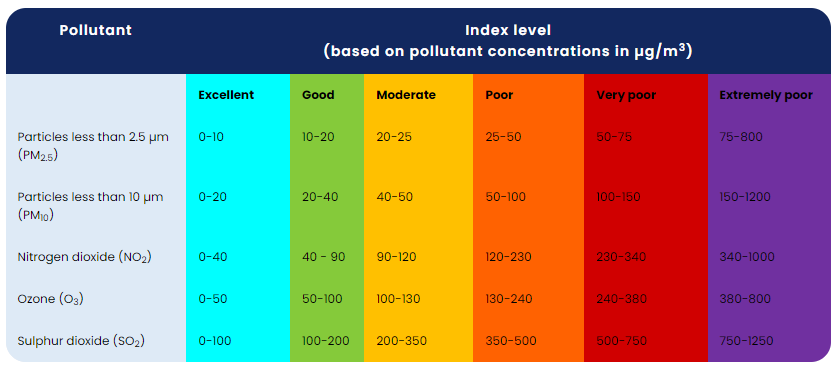

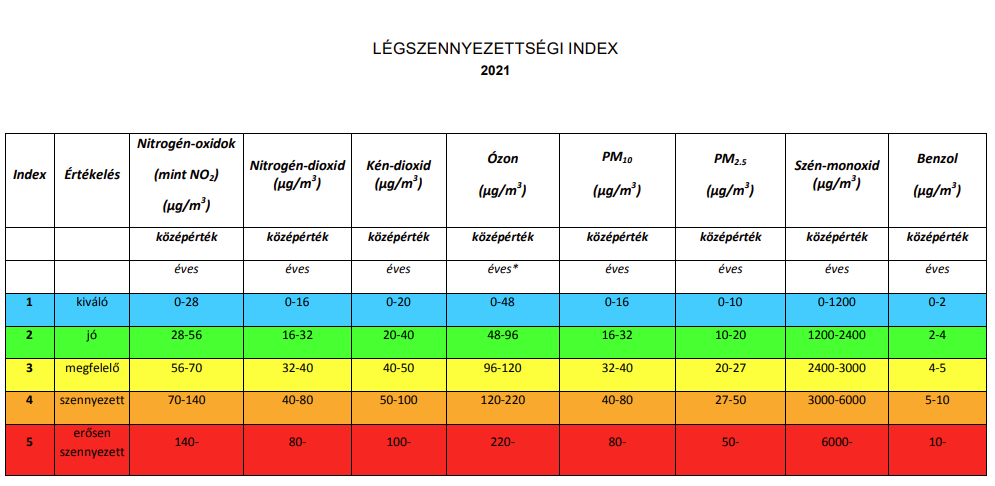

In [290]:
RANGES = {}
RANGES["PM25"] = {}
"""RANGES["PM25"] = {"Excellent" : (range(0,10), 1), "Good" : (range(10,20),2), 
                  "Moderate": (range(20,25),2), "Poor": (range(25,50),3),
                 "Very Poor": (range(50,75),4), "Extremely Poor": (range(75,800),5)}"""
# new one 2021
RANGES["PM25"] = {"Excellent" : (range(0,10), 1), "Good" : (range(10,20),2), 
                  "Moderate": (range(20,27),3), "Poor": (range(27,50),4),
                 "Very Poor": (range(50,1000),5)}

RANGES["PM10"] = {}

"""RANGES["PM10"] = {"Excellent" : (range(0,20), 1), "Good" : (range(20,40),2), 
                  "Moderate": (range(40,50),3), "Poor": (range(50,100),4),
                 "Very Poor": (range(100,150),5), "Extremely Poor": (range(150,1200),5)}"""

RANGES["PM10"] = {"Excellent" : (range(0,16), 1), "Good" : (range(16,32),2), 
                  "Moderate": (range(32,40),3), "Poor": (range(40,80),4),
                 "Very Poor": (range(80,1000),5)}

RANGES["NO2"] = {}

"""# https://legszennyezettseg.met.hu/en/air-quality/aq-index-information # old one
RANGES["NO2"] = {"Excellent" : (range(0,40), 1), "Good" : (range(40,90),2), 
                  "Moderate": (range(90,120),2), "Poor": (range(120,230),3),
                 "Very Poor": (range(230,340),4), "Extremely Poor": (range(340,1000),5)}
"""
# https://legszennyezettseg.met.hu/storage/media/ertekelesek/2021_RIV%20ertekeles_v2.pdf
RANGES["NO2"] = {"Excellent" : (range(0,16), 1), "Good" : (range(16,32),2), 
                  "Moderate": (range(32,40),3), "Poor": (range(40,80),4),
                 "Very Poor": (range(80,1000),5)}

RANGES["O3"] = {}

"""RANGES["O3"] = {"Excellent" : (range(0,50), 1), "Good" : (range(50,100),2), 
                  "Moderate": (range(100,130),2), "Poor": (range(130,240),3),
                 "Very Poor": (range(240,380),4), "Extremely Poor": (range(380,800),5)}"""

RANGES["O3"] = {"Excellent" : (range(0,48), 1), "Good" : (range(48,96),2), 
                  "Moderate": (range(96,120),3), "Poor": (range(120,220),4),
                 "Very Poor": (range(220,1000),5)}

RANGES["CO"] = {}

RANGES["CO"] = {"Excellent" : (range(0,1200), 1), "Good" : (range(1200,2400),2), 
                  "Moderate": (range(2400,3000),3), "Poor": (range(3000,6000),4),
                 "Very Poor": (range(6000,10000),5)}

# missing SO2 - Kén dioxid
# RANGES["PM25"] = {range(0,10) : "Excellent"}

In [343]:
FOCUS = "NO2"
b = m.gpd.read_parquet(PATH["weather-processed"]+FOCUS+".parquet")
display(b.head())
print(set(b["unit"]))
b = airQualityIndexTranslater(b, FOCUS)
display(b.head())

,lon,lat,geometry,unit,NO2-max,NO2-avg,QualityString,QualityInt
0,16.1,45.7,"POLYGON ((16.00000 45.70000, 16.10000 45.70000...",ug/m3,7.0,7.0,1,Excellent
1,16.2,45.7,"POLYGON ((16.10000 45.70000, 16.20000 45.70000...",ug/m3,6.0,6.0,1,Excellent
2,16.3,45.7,"POLYGON ((16.20000 45.70000, 16.30000 45.70000...",ug/m3,5.0,5.0,1,Excellent
3,16.4,45.7,"POLYGON ((16.30000 45.70000, 16.40000 45.70000...",ug/m3,5.0,5.0,1,Excellent
4,16.5,45.7,"POLYGON ((16.40000 45.70000, 16.50000 45.70000...",ug/m3,5.0,4.0,1,Excellent


{'ug/m3'}


,lon,lat,geometry,unit,NO2-max,NO2-avg,QualityString,QualityInt
0,16.1,45.7,"POLYGON ((16.00000 45.70000, 16.10000 45.70000...",ug/m3,7.0,7.0,Excellent,1
1,16.2,45.7,"POLYGON ((16.10000 45.70000, 16.20000 45.70000...",ug/m3,6.0,6.0,Excellent,1
2,16.3,45.7,"POLYGON ((16.20000 45.70000, 16.30000 45.70000...",ug/m3,5.0,5.0,Excellent,1
3,16.4,45.7,"POLYGON ((16.30000 45.70000, 16.40000 45.70000...",ug/m3,5.0,5.0,Excellent,1
4,16.5,45.7,"POLYGON ((16.40000 45.70000, 16.50000 45.70000...",ug/m3,5.0,4.0,Excellent,1


In [344]:
b = airQualityIndexTranslater(b, FOCUS)
display(b.head())
b.to_parquet(PATH["weather-processed"]+FOCUS+".parquet")

,lon,lat,geometry,unit,NO2-max,NO2-avg,QualityString,QualityInt
0,16.1,45.7,"POLYGON ((16.00000 45.70000, 16.10000 45.70000...",ug/m3,7.0,7.0,Excellent,1
1,16.2,45.7,"POLYGON ((16.10000 45.70000, 16.20000 45.70000...",ug/m3,6.0,6.0,Excellent,1
2,16.3,45.7,"POLYGON ((16.20000 45.70000, 16.30000 45.70000...",ug/m3,5.0,5.0,Excellent,1
3,16.4,45.7,"POLYGON ((16.30000 45.70000, 16.40000 45.70000...",ug/m3,5.0,5.0,Excellent,1
4,16.5,45.7,"POLYGON ((16.40000 45.70000, 16.50000 45.70000...",ug/m3,5.0,4.0,Excellent,1


In [317]:
def airQualityIndexTranslater(df, FOCUS):
    l = list(RANGES[FOCUS].keys()) #keys, excellent, moderate, whatever
    #print(l)
    emptyQV = []
    emptyQString = []
    for _, r in df.iterrows():
        for i in l:
            if r[str(FOCUS+"-avg")] in RANGES[FOCUS][i][0]:
            #print(RANGES["PM25"][i])
                emptyQString.append(i) # level
                emptyQV.append(RANGES[FOCUS][i][1]) # value
    df["QualityString"] = emptyQString
    df["QualityInt"] = emptyQV
    
    return df

In [320]:
# airQualityIndexTranslater(b, FOCUS).explore("QualityInt", cmap="Blues")

## convert ppb to ug/m3

In [335]:
b["CO-avg"] = (d["CO-avg"] * 1.15).astype(int)
b["CO-max"] = (d["CO-max"] * 1.15).astype(int)
b.unit = "ug/m3"

## PM2.5 discrepancy 

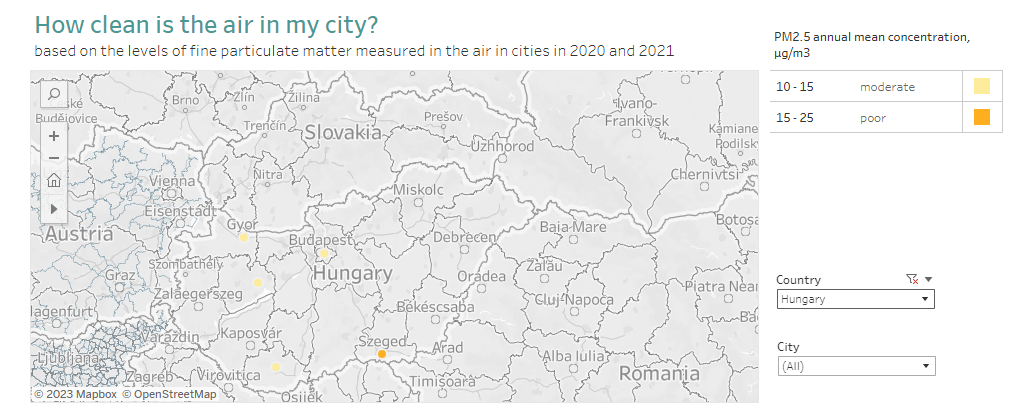

## OVERALL AIR Quality calculation 

In [360]:
ll = []
for mes in MEASURES:
    # read in the file
    b = m.gpd.read_parquet(PATH["weather-processed"]+FOCUS+".parquet")
    l = list(b["QualityInt"])
    ll.append(l)
    # make a list about the QualityInt
    # add to a numpy array [, , ,]
    # find max
    # map it
valueLists = np.column_stack(ll)
lll = np.rint(np.amax(valueLists, axis=1))

In [355]:
dummy = m.gpd.read_parquet(PATH["weather-processed"]+FOCUS+".parquet")

In [357]:
dummy["OverallQualityIn"] = lll

In [364]:
dummy.drop(columns=['unit', 'NO2-max', "NO2-avg", "QualityString", "QualityInt", "lon", "lat"], inplace=True)

In [369]:
dicty = {1:"Excellent", 2:"Good", 3:"Moderate", 4:"Poor"}
qualityString = []
for _, r in dummy.iterrows():
    qualityString.append(dicty[r.OverallQualityIn])

In [372]:
dummy["OverallQualityString"] = qualityString

In [375]:
import mainloc as mdummy.to_parquet(PATH["weather-processed"]+"OVERALL"+".parquet")

In [6]:
import streamlitclasses as stc
import mainloc as m
PATH = {}
PATH["weather"] = "data/weather/unprocessed/"
PATH["weather-processed"] = "data/weather/processed/"
airqualityDict = m.defaultdict(str)
airqualityRanges = m.defaultdict(int)
    
for i in stc.AIRMEASURES:
    airqualityDict[str(i)] = m.gpd.read_parquet(PATH["weather-processed"]+ i + ".parquet")
    l = set(airqualityDict[str(i)]["QualityInt"])
    print(l)

{1, 2, 3}
{2}
{1}
{1, 2}
{1, 2}


KeyError: 'QualityInt'

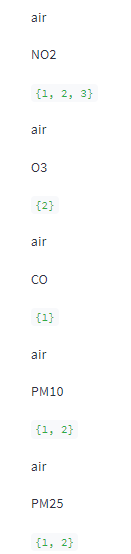